<a href="https://colab.research.google.com/github/YagmurTaze/OCR-ICR/blob/main/1_Handwriting_Letters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

## Functions

In [2]:
def apply_contrast(image, contrast):
    # Görüntüyü gri tonlamaya dönüştür
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Yeni bir görüntü oluşturmak için gri tonlamalı görüntüyü kopyala, orijinal resmi korur
    contrast_image = np.copy(image)

    # Kontrastı uygula
    for i in range(contrast_image.shape[0]):
        for j in range(contrast_image.shape[1]):
            for k in range(3):
                new_value = contrast * (contrast_image[i, j, k] - 128) + 128
                if new_value < 0:
                    new_value = 0
                elif new_value > 255:
                    new_value = 255
                contrast_image[i, j, k] = new_value

    return contrast_image

In [3]:
def thresholding(image):
    img_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(img_gray,80,255,cv2.THRESH_BINARY_INV)
    plt.imshow(thresh, cmap='gray')
    return thresh

In [4]:
def resize_image(img):
    # Görüntünün boyutlarını alın
    height, width, _ = img.shape

    #Yeniden boyutlandırma oranını hesaplayın
    rescale_factor = min(64 / height, 64 / width)

    # Yeniden boyutlandırılmış görüntü boyutlarını hesaplayın
    new_height = int(height * rescale_factor)
    new_width = int(width * rescale_factor)

    # Yeniden boyutlandırma işlemi
    resized_image = cv2.resize(img, (new_width, new_height))

    # Yeniden boyutlandırılmış görüntüyü 64x64 boyutlarına ekleyin
    border_top = (64 - new_height) // 2
    border_bottom = 64 - new_height - border_top
    border_left = (64 - new_width) // 2
    border_right = 64 - new_width - border_left
    padded_image = cv2.copyMakeBorder(resized_image, border_top, border_bottom, border_left, border_right, cv2.BORDER_CONSTANT, value=[255, 255, 255])  # Beyaz arka plan ekleme
    padded_image = np.expand_dims(padded_image, axis = 0)

    return padded_image

## Load The Model

In [5]:
model = load_model("byLettermodel.h5")

## Preprocess The Image

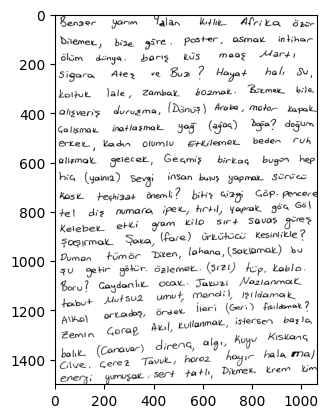

In [195]:
img = cv2.imread('/content/third.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img = apply_contrast(img, 7)
thresh_img = thresholding(img);

plt.imshow(img);

## Dilations & Segmentations & Prediction

In [196]:
def line_segmentation(img):

  img_new = img.copy()

  kernel = np.ones((5,85), np.uint8)
  dilated = cv2.dilate(thresh_img, kernel, iterations = 1)

  (contours, heirarchy) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  sorted_contours_lines = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[1]) # (x, y, w, h)

  cropped_lines = []

  for ctr in sorted_contours_lines:

    x,y,w,h = cv2.boundingRect(ctr)

    cropped_line = img[y:y+h, x:x+w].copy()
    cropped_lines.append(cropped_line)

    img_new = cv2.rectangle(img_new, (x,y), (x+w, y+h), (40, 100, 250), 2)
  plt.imshow(dilated, cmap='gray')
  plt.title('Dilated Image')
  plt.show()

  return cropped_lines,img_new

In [197]:
def word_segmentation(img):

  img_new = img.copy()

  thresh_img = thresholding(img)

  kernel = np.ones((10,20), np.uint8)
  dilated = cv2.dilate(thresh_img, kernel, iterations = 1)

  (contours, heirarchy) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  sorted_contours_words = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[0]) # (x, y, w, h)

  cropped_words = []

  for ctr in sorted_contours_words:

    x,y,w,h = cv2.boundingRect(ctr)

    cropped_line = img[y:y+h, x:x+w].copy()
    cropped_words.append(cropped_line)

    img_new = cv2.rectangle(img_new, (x,y), (x+w, y+h), (40, 100, 250), 2)

  plt.imshow(dilated, cmap='gray')
  plt.title('Dilated Image')
  plt.show()

  return cropped_words, img_new

In [198]:
def letter_segmentation(img):

  img_new = img.copy()

  img = apply_contrast(img, 7)
  thresh_img = thresholding(img);

  kernel = np.ones((20,1), np.uint8)
  dilated = cv2.dilate(thresh_img, kernel, iterations = 1)

  (contours, heirarchy) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  sorted_contours_letters = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[0]) # (x, y, w, h)

  cropped_letters = []

  for ctr in sorted_contours_letters:

    x,y,w,h = cv2.boundingRect(ctr)

    cropped_line = img[y:y+h, x:x+w].copy()
    cropped_letters.append(cropped_line)

    img_new = cv2.rectangle(img_new, (x,y), (x+w, y+h), (40, 100, 250), 2)

  return cropped_letters, img_new

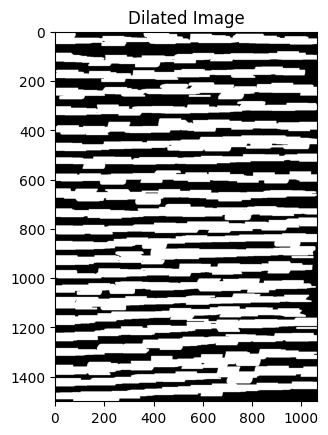

In [199]:
lines, new = line_segmentation(img)

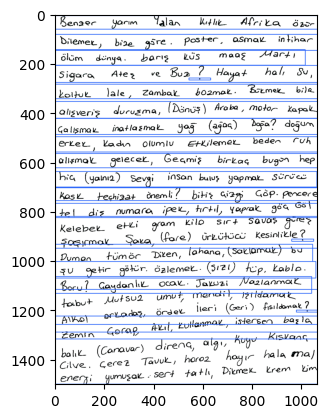

In [200]:
plt.imshow(new)

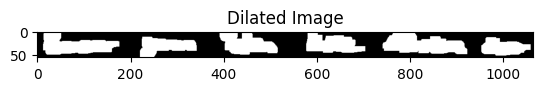

In [201]:
words, new = word_segmentation(lines[0])

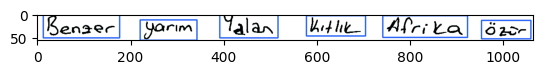

In [202]:
plt.imshow(new)

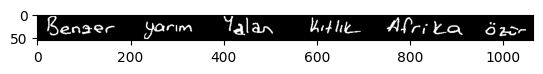

In [203]:
letters, new = letter_segmentation(lines[0])

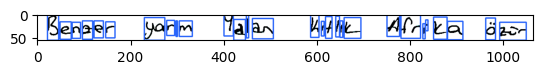

In [204]:
plt.imshow(new)

In [ ]:
text = ""
lines, _ = line_segmentation(img)

for line in lines:


  plt.imshow(line);
  words, _ = word_segmentation(line)

  for word in words:

    letters, _ = letter_segmentation(word)

    predicted_letters = []

    for img_array in letters:
        img_array_resized = resize_image(img_array)

        # Tahmin yapma
        result = model.predict(img_array_resized)
        predicted_class_index = np.argmax(result)
        alphabet = '0123456789ABCÇDEFGĞHIİJKLMNOÖPRSŞTUÜVYZabcçdefgğhıijklmnoöprsştuüvyz'
        predicted_letter = alphabet[predicted_class_index]

        predicted_letters.append(predicted_letter)
        text += predicted_letter
    text += " "
  text += "\n"

print()
print(text)